In [1]:
from PIL import Image
import sys
import numpy as np
import random
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

## Let's load in the image, do a few image checks, then get all of the pixel data

In [2]:
def get_image(image_path):
    print("Loading the image...")
    image = Image.open(image_path, 'r')
    width, height = image.size
    while width > 2000 and height > 2000:
        print("Image too large, downsizing by factor of 2...")
        image = image.resize((int(width/2),int(height/2)),Image.ANTIALIAS)
        width, height = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    elif image.mode == 'RGBA':
        channels = 3
        for px in pixel_values:
            px = list(px)
            R,G,B,A = px
            px[0] = ((1-A)*R) + A*R
            px[1] = ((1-A)*G) + A*G
            px[2] = ((1-A)*B) + A*B
            del px[3]
            px = tuple(px)
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    return pixel_values,image.mode,image.size

Loading the image...


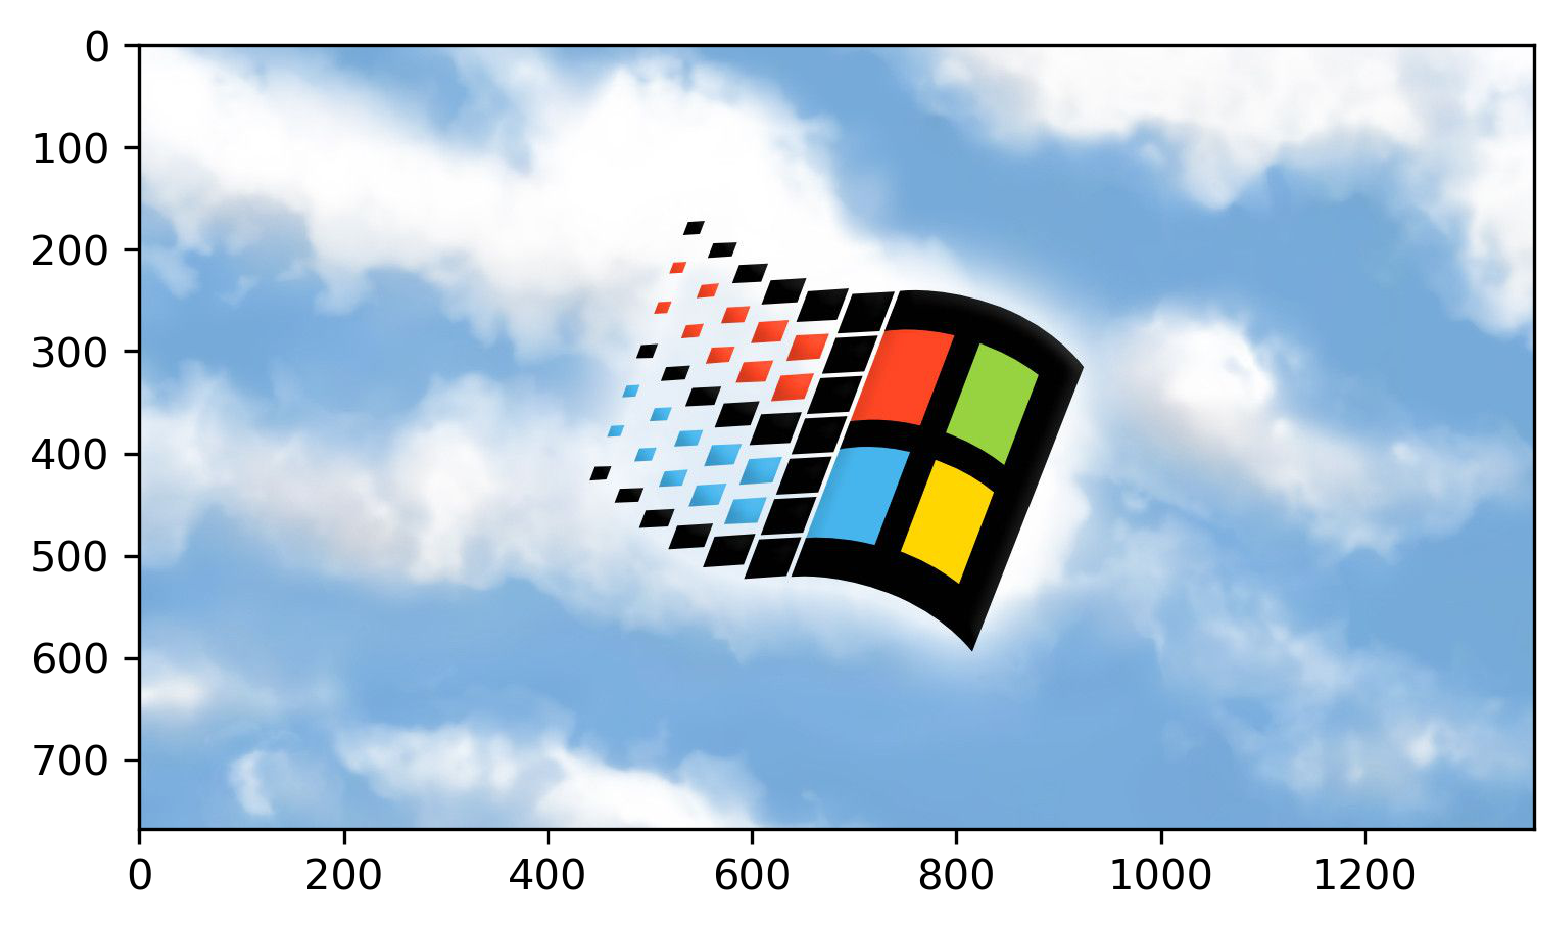

In [10]:
def show_original(PATH):
    origTuple,origmode,origsize = get_image(PATH)
    orig = list(map(list,origTuple))
    dataOut = [tuple(d) for d in orig]
    imOrig = Image.new(origmode,origsize)
    imOrig.putdata(dataOut)
    plt.figure(dpi=300)
    plt.imshow(imOrig);
    
show_original("./testimage.jpg")

In [3]:
k=10
dataTuple,mode,size = get_image('./testimage.jpg')
data = list(map(list,dataTuple))
numpx = len(data)
print("Checking for sanity...")
unique_colors = len([list(x) for x in set(tuple(x) for x in data)])
if k > unique_colors:
    print("Fewer colors than requested clusters")
    sys.exit(1)

Loading the image...
Checking for sanity...


## Let's take a look at the image in RGB space

In [4]:
import pandas as pd
df = pd.DataFrame(data, columns=['Red','Green','Blue'])

In [5]:
def get_rgb(row):
    return (row['Red']/255.,row['Green']/255.,row['Blue']/255.)

df['rgb'] = df.apply(get_rgb, axis=1)

In [6]:
df.sample(10)

Red  Green  Blue                                                rgb
510096     0      6    12            (0.0, 0.0235294117647, 0.0470588235294)
685621   120    171   218   (0.470588235294, 0.670588235294, 0.854901960784)
1042375  140    185   224   (0.549019607843, 0.725490196078, 0.878431372549)
798931   122    174   221   (0.478431372549, 0.682352941176, 0.866666666667)
48845    248    248   248   (0.972549019608, 0.972549019608, 0.972549019608)
716759   179    210   231   (0.701960784314, 0.823529411765, 0.905882352941)
140539   192    213   230   (0.752941176471, 0.835294117647, 0.901960784314)
332698    15     15    15  (0.0588235294118, 0.0588235294118, 0.058823529...
511715   151    211    64   (0.592156862745, 0.827450980392, 0.250980392157)
872202   126    177   224   (0.494117647059, 0.694117647059, 0.878431372549)

In [7]:
df.shape

(1049088, 4)

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def draw_3d_color_plots(df, alph = 0.5, size = 50):
    new_df = df.drop_duplicates()
    if new_df.shape[0] > 20000:
        print("More than 20000 points, sampling 20000 from %i points."%new_df.shape[0])
        new_df = new_df.sample(20000, replace=False)
    fig = plt.figure(figsize=(20,16))
    ax = fig.gca(projection='3d')
    ax.scatter(new_df['Red'],new_df['Green'],
               new_df['Blue'],c=new_df['rgb'], s=size, alpha=alph);
    ax.set_xlabel('Red', fontsize=20, labelpad=20)
    ax.set_ylabel('Green', fontsize=20, labelpad=20)
    ax.set_zlabel('Blue', fontsize=20, labelpad=20);
    return ax
    
def clean_and_draw_3d(link_to_image):
    print("This will take a minute to process... please wait.")
    dataTuple,mode,size = get_image(link_to_image)
    data = list(map(list,dataTuple))
    df_temp = pd.DataFrame(data, columns=['Red','Green','Blue'])
    def get_rgb(row):
        return (row['Red']/255.,row['Green']/255.,row['Blue']/255.)
    df_temp['rgb'] = df_temp.apply(get_rgb, axis=1)
    draw_3d_color_plots(df_temp)
    

More than 20000 points, sampling 20000 from 28536 points.


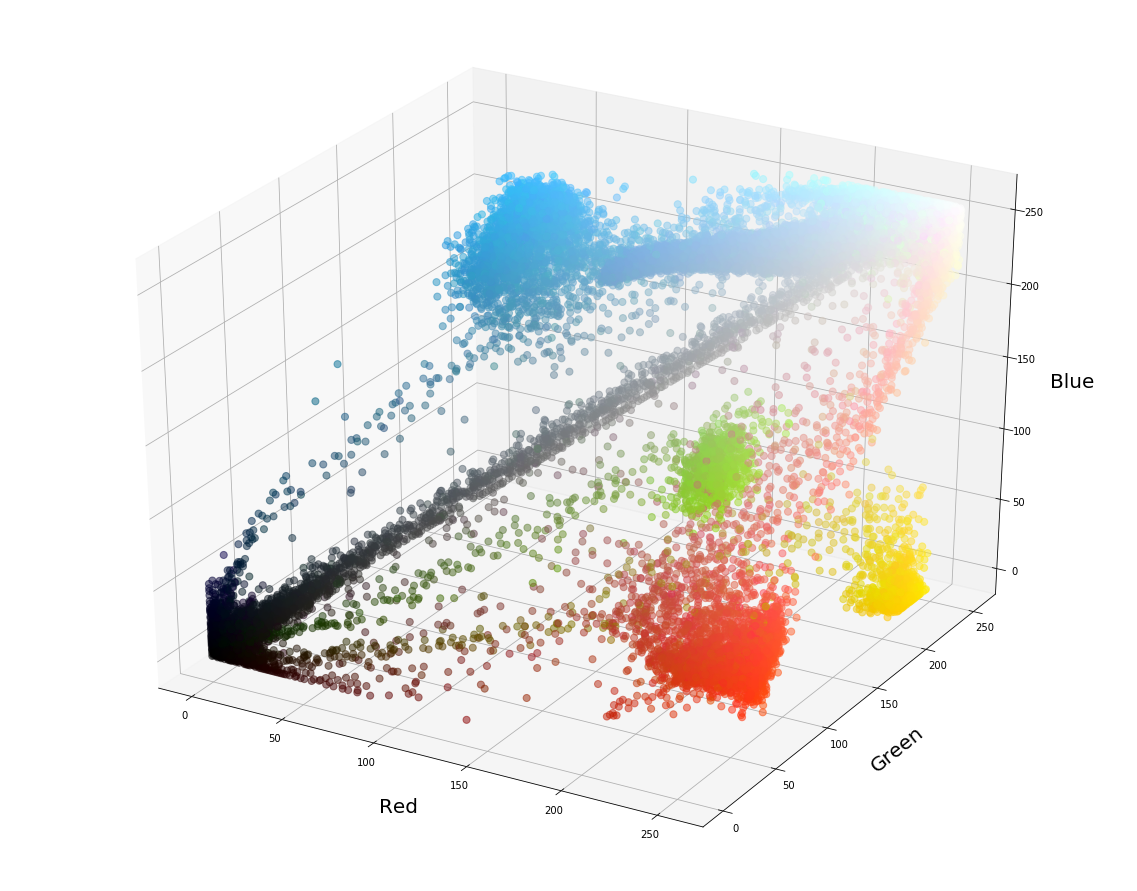

In [9]:
ax = draw_3d_color_plots(df)

## Cool, so we can see there are already some clusters happening, but we want to quantify that. Let's use KMeans.

In [28]:
print("Finding " + str(k) + " color clusters and appropriate replacement colors...")
print("(This can take a while. Your image has " + str(numpx) + " pixels to analyze")
print("and " + str(unique_colors) + " unique colors. The length of time depends on number of pixels,")
print("number of colors in image and the number of requested output colors.)")
print("... Please be patient ...")
estimator = KMeans(n_clusters=k, n_init=10, init='k-means++')
pixel_labels = estimator.fit_predict(data)
means = estimator.cluster_centers_

Finding 10 color clusters and appropriate replacement colors...
(This can take a while. Your image has 1049088 pixels to analyze
and 28536 unique colors. The length of time depends on number of pixels,
number of colors in image and the number of requested output colors.)
... Please be patient ...


Now that we have the means, let's go through and set every point to whatever mean is closest to it. This will be the posterizing.

In [29]:
print("Preparing image for output...")
for i, clst in enumerate(pixel_labels):
    if not i%500000 and numpx > 500000:
        print("Processing pixel " + str(i) + " / " + str(numpx) + "...")
    elif not i%500000:
        print("Processing pixels.")
    data[i] = list(map(int, means[clst]))

dataOut = [tuple(d) for d in data]

im2 = Image.new(mode,size)
im2.putdata(dataOut)

Preparing image for output...
Processing pixel 0 / 1049088...
Processing pixel 500000 / 1049088...
Processing pixel 1000000 / 1049088...


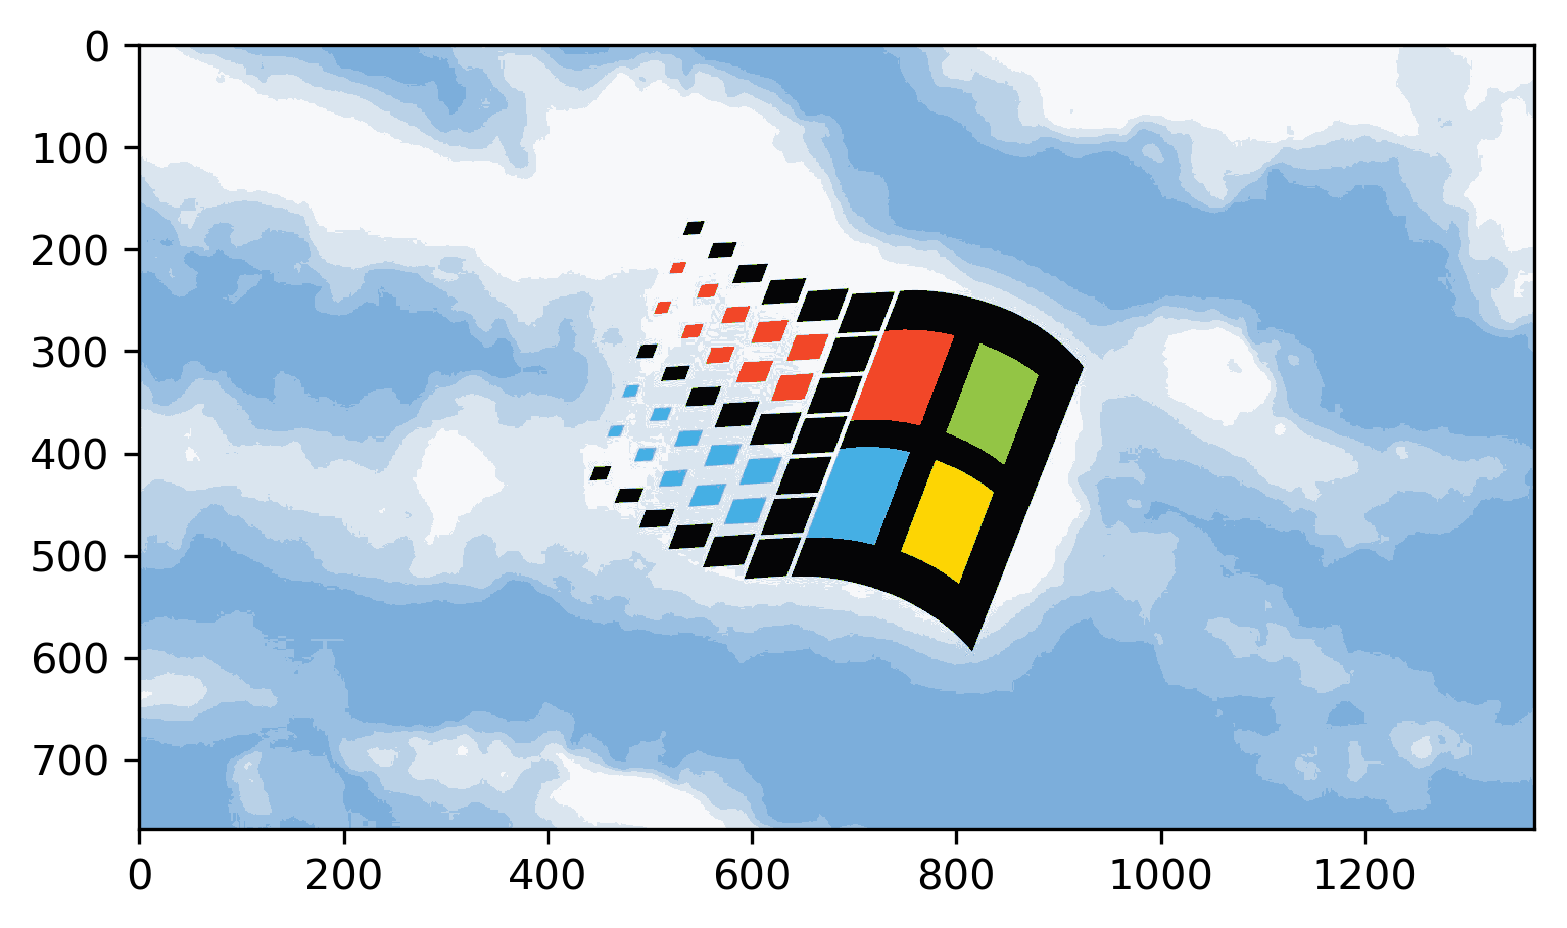

In [30]:
plt.figure(dpi=300)
plt.imshow(im2)

In [32]:
df = pd.DataFrame(data, columns=['Red','Green','Blue'])
df.drop_duplicates(inplace=True)
df['rgb'] = df.apply(get_rgb, axis=1)
df

Red  Green  Blue                                                rgb
0       247    248   250    (0.96862745098, 0.972549019608, 0.980392156863)
30      218    229   239   (0.854901960784, 0.898039215686, 0.937254901961)
48      185    209   231   (0.725490196078, 0.819607843137, 0.905882352941)
90      153    191   226              (0.6, 0.749019607843, 0.886274509804)
155     124    174   219   (0.486274509804, 0.682352941176, 0.858823529412)
236865  147    197    69   (0.576470588235, 0.772549019608, 0.270588235294)
236868    5      5     6  (0.0196078431373, 0.0196078431373, 0.023529411...
291488  242     71    40   (0.949019607843, 0.278431372549, 0.156862745098)
456724   69    175   228   (0.270588235294, 0.686274509804, 0.894117647059)
558108  253    213     3  (0.992156862745, 0.835294117647, 0.0117647058824)

In [33]:
df.shape

(10, 4)

Note that there are now only `k` rows since we dropped all duplicates!

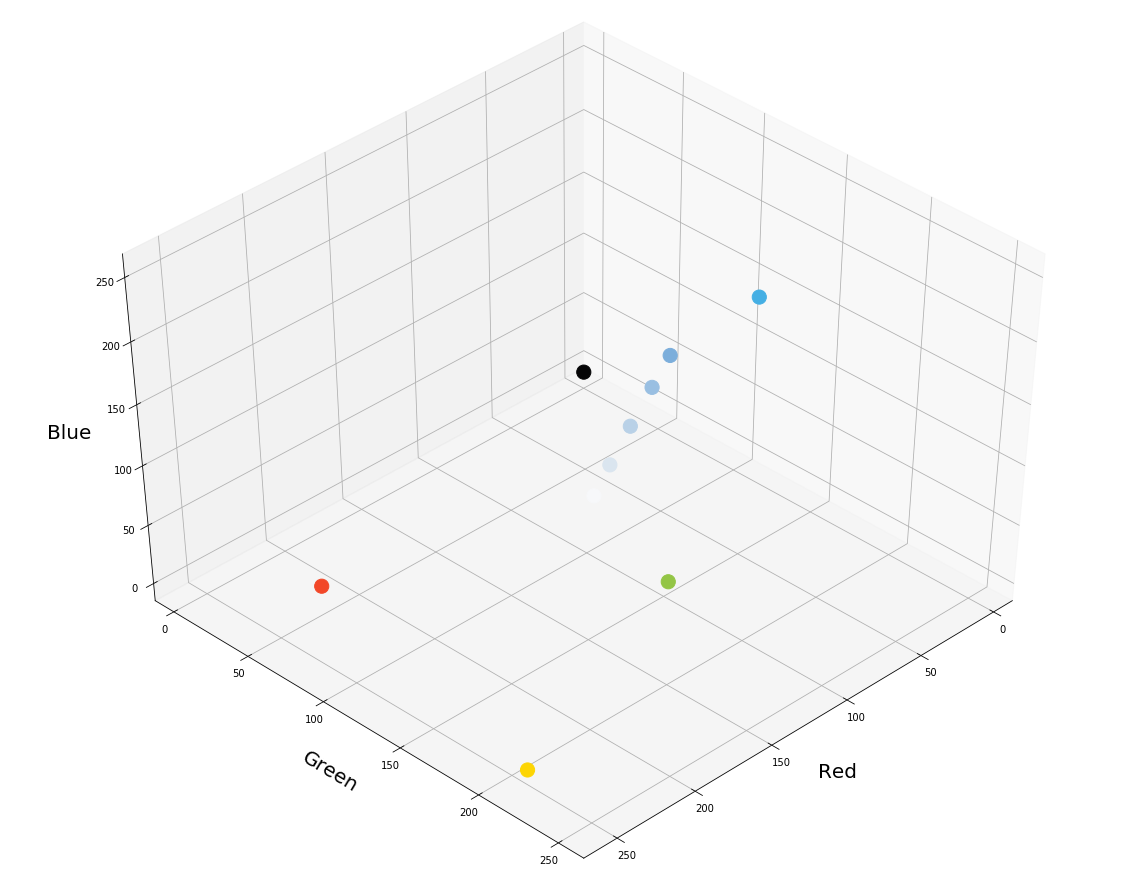

In [34]:
ax = draw_3d_color_plots(df, alph=1, size=200)
ax.view_init(45,45)

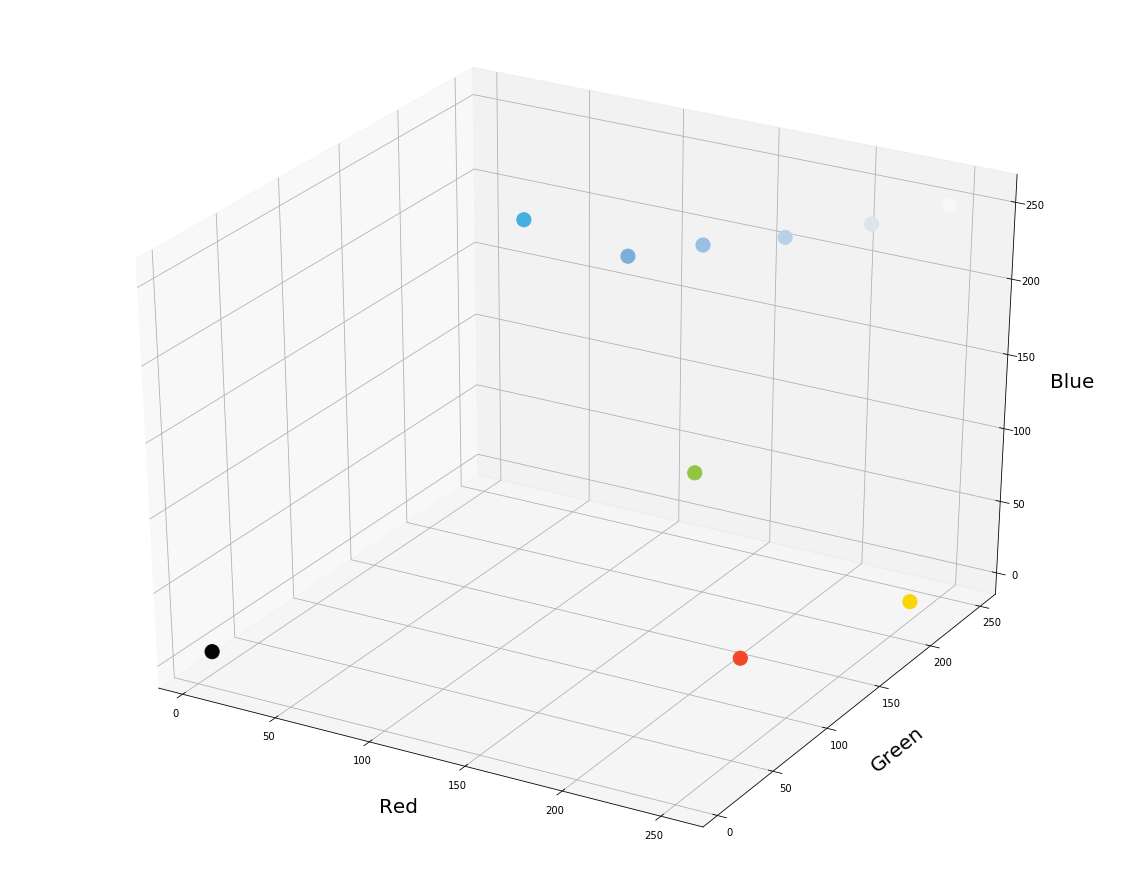

In [35]:
ax = draw_3d_color_plots(df, alph=1, size=200)

# Now let's put it in a big function (without the diagnostic plots) so we can view the results quickly.

In [18]:
def posterize_image(k, path):
    dataTuple,mode,size = get_image(path)
    data = list(map(list,dataTuple))
    numpx = len(data)
    print("Checking for sanity...")
    unique_colors = len([list(x) for x in set(tuple(x) for x in data)])
    if k > unique_colors:
        print("Fewer colors than requested clusters")
        return None
        
    print("Finding " + str(k) + " color clusters and appropriate replacement colors...")
    print("(This can take a while. Your image has " + str(numpx) + " pixels to analyze")
    print("and " + str(unique_colors) + " unique colors. The length of time depends on number of pixels,")
    print("number of colors in image and the number of requested output colors.)")
    print("... Please be patient ...")
    estimator = KMeans(n_clusters=k, n_init=10, init='k-means++')
    pixel_labels = estimator.fit_predict(data)
    means = estimator.cluster_centers_
    
    print("Preparing image for output...")
    for i, clst in enumerate(pixel_labels):
        if not i%500000 and numpx > 500000:
            print("Processing pixel " + str(i) + " / " + str(numpx) + "...")
        elif not i%500000:
            print("Processing pixels.")
        data[i] = list(map(int, means[clst]))

    dataOut = [tuple(d) for d in data]

    im2 = Image.new(mode,size)
    im2.putdata(dataOut)
    
    plt.figure(dpi=300)
    plt.imshow(im2)
    

This will take a minute to process... please wait.
Loading the image...
More than 20000 points, sampling 20000 from 162460 points.


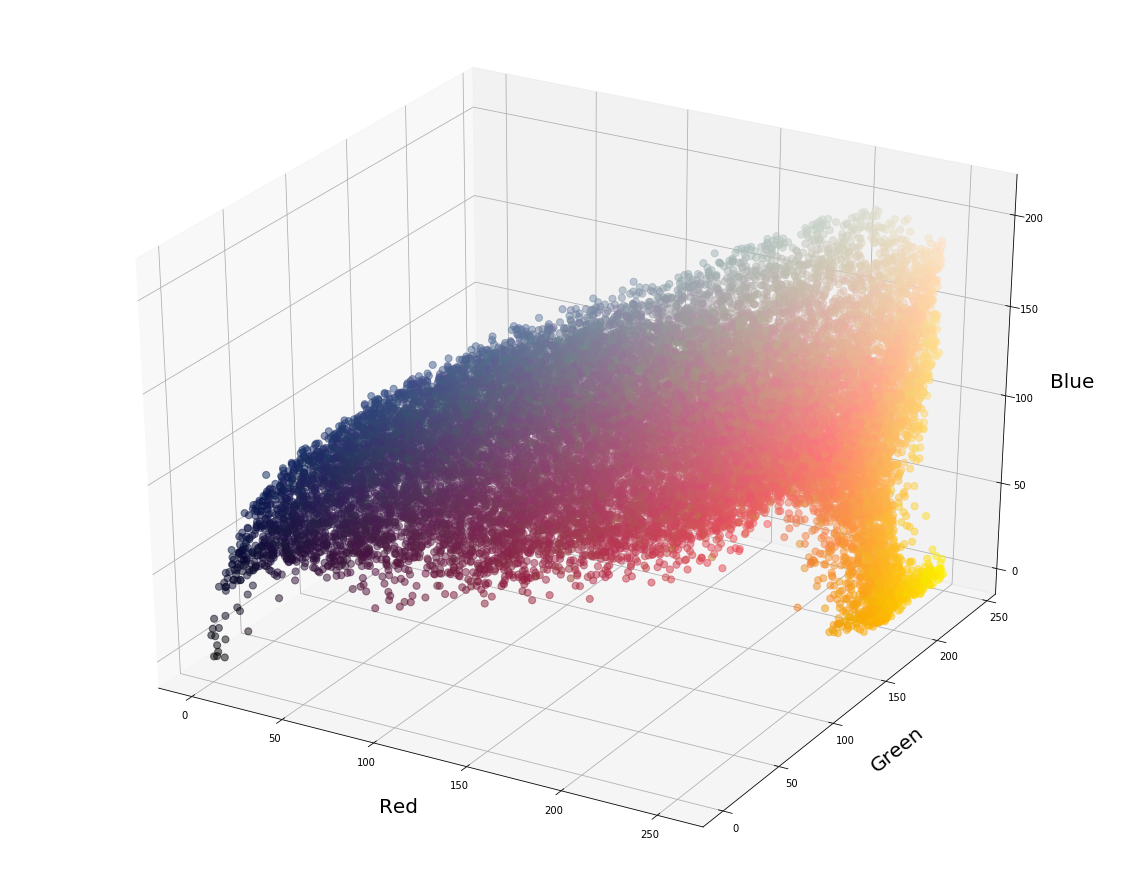

In [16]:
PATH = './sunset.jpg'
clean_and_draw_3d(PATH)

Loading the image...
Checking for sanity...
Finding 4 color clusters and appropriate replacement colors...
(This can take a while. Your image has 1024000 pixels to analyze
and 162460 unique colors. The length of time depends on number of pixels,
number of colors in image and the number of requested output colors.)
... Please be patient ...
Preparing image for output...
Processing pixel 0 / 1024000...
Processing pixel 500000 / 1024000...
Processing pixel 1000000 / 1024000...


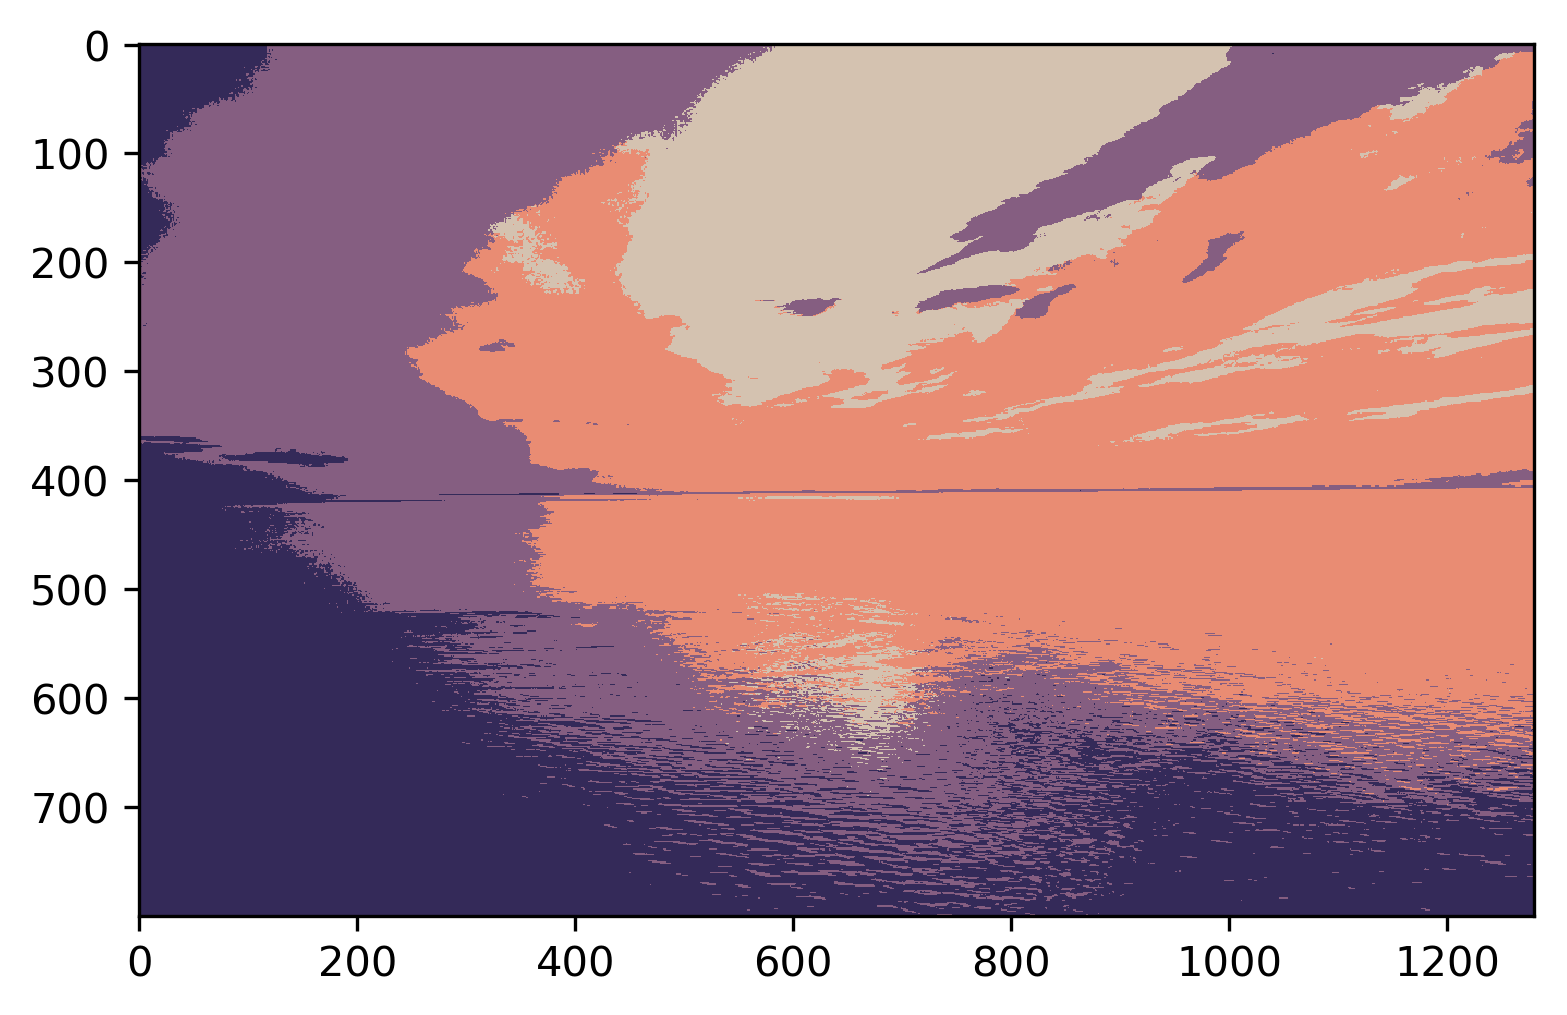

In [19]:
posterize_image(4, PATH)

And here's the original

Loading the image...


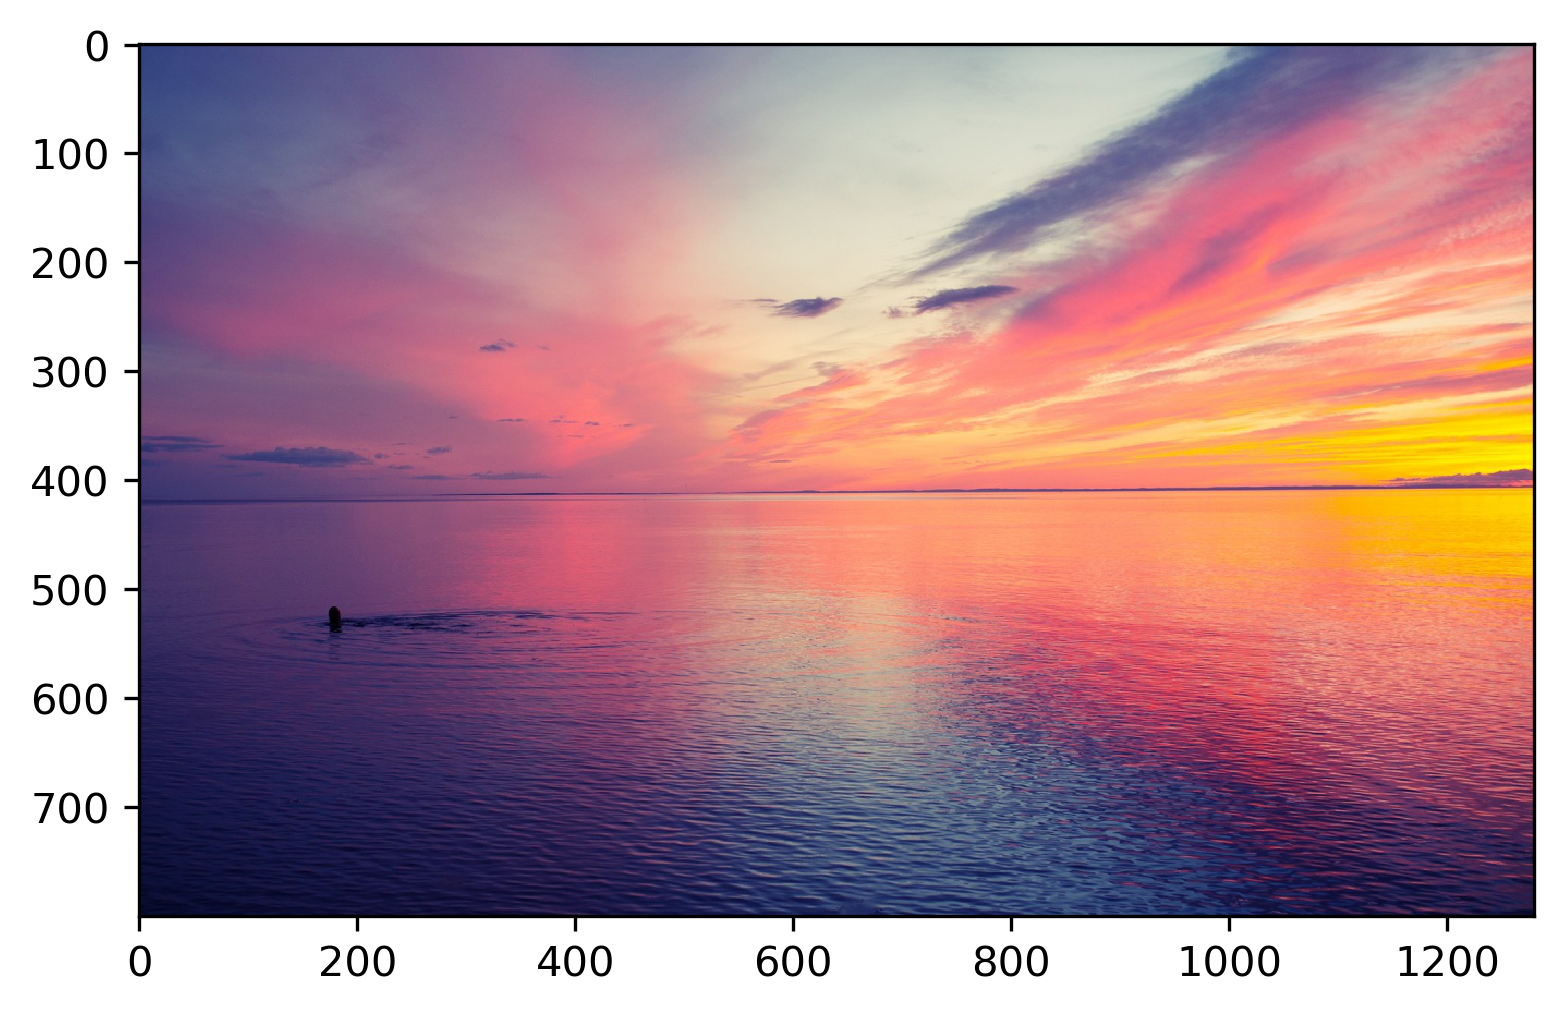

In [20]:
show_original(PATH)